# **<font color=blue>201819_MIIA4406_01 - DEEP LEARNING Y REDES NEURONAL</font>** 
# UNIVERSIDAD DE LOS ANDES
## Final Project: [Movie Genre Classification](https://www.kaggle.com/c/miia4406-movie-genre-classification)
by [Andrés Felipe Villabona Lozada - COD: 201727965](https://github.com/AndresFelipeVillabonaLozada)
& Camilo Torres Rodríguez - COD: 200714035

July-23-2018
<img src="moviegenre.png">
### Classify a movie genre based on its plot and its poster.

### Data
Input:

* movie plot
* movie image

Output: Probability of the movie belong to each genre

### Evaluation

1. 10% Create a solution using both images and text with a Machine Learning algorithm
* 40% Create a solution using both images and text with a Deep Learning algorithm (CNN, transfer learning, RNN)
* 30% Presentation (5 slides)
* 20% Performance in the Kaggle competition (Normalized acording to class performance in the private leaderboard)

### Acknowledgements
We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

# **<font color=blue>Development</font>**
### Import library

In [1]:
import pandas as pd
import os
import numpy as np
from skimage import io
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import History
from keras.utils import np_utils
from livelossplot import PlotLossesKeras
from keras.optimizers import RMSprop
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
%matplotlib inline

C:\Users\avill\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Read movie plot data

In [2]:
path = "C:/Users/avill/Desktop/DeepLearning/AppliedDeepLearningClass-master Parte 4/finalProject/"
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dataTraining.shape

(7895, 5)

In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [6]:
dataTesting.shape

(3383, 3)

### Read movie image data

In [104]:
image = io.imread(os.path.join(path, 'images', str(dataTraining.index[6]) + '.jpeg'))
#image

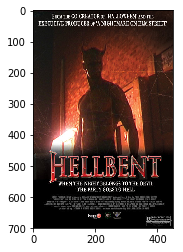

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

In [10]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

images_training = np.stack(images_training)
images_training.shape, dataTraining.shape[0]

100%|██████████| 7895/7895 [03:16<00:00, 40.18it/s]


((7895, 40960), 7895)

In [11]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

images_testing = np.stack(images_testing)
images_testing.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:53<00:00, 62.88it/s]


((3383, 40960), 3383)

### Create Y

In [7]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

### Plot genres frequencies

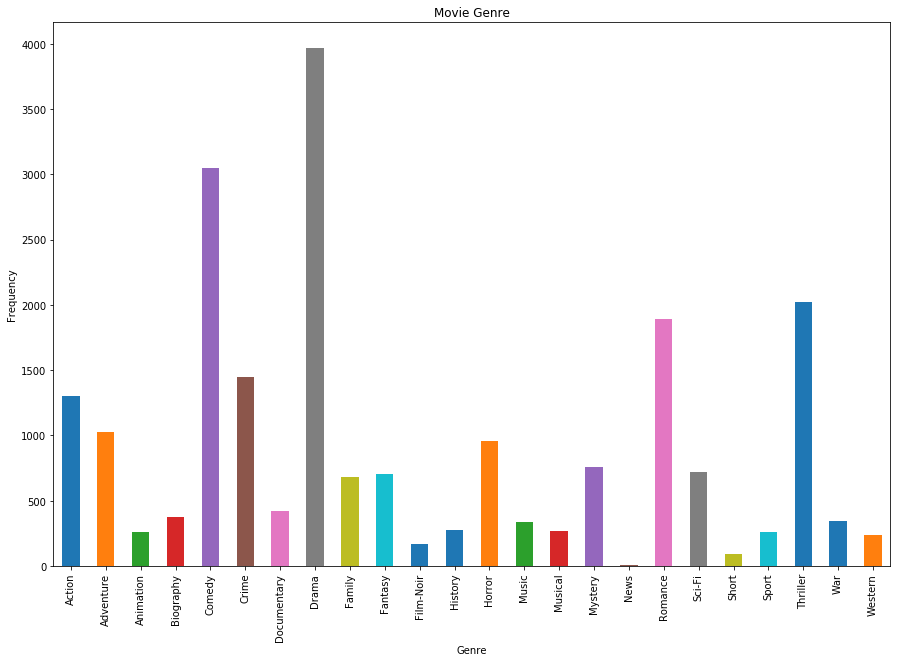

In [8]:
frequencies = [sum(x) for x in zip(*y_genres)]
generos = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
        'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',
        'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']
freq_series = pd.Series.from_array(frequencies)

plt.figure(figsize=(15, 10))
ax = freq_series.plot(kind='bar')
ax.set_title('Movie Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Frequency')
ax.set_xticklabels(generos)
rects = ax.patches

# **<font color=blue>1. Solution using both images and text with a Machine Learning algorithm</font>**

### Create count vectorizer with ngrams

In [12]:
vect = CountVectorizer(lowercase=False, stop_words='english', ngram_range=(1, 2), max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [13]:
print(vect.get_feature_names()[:50])

['abandoned', 'able', 'accepts', 'accident', 'accidentally', 'act', 'action', 'actor', 'actress', 'actually', 'adam', 'adult', 'adventure', 'advice', 'affair', 'age', 'aged', 'agent', 'agents', 'ago', 'agrees', 'air', 'alan', 'alex', 'alice', 'alien', 'alive', 'america', 'american', 'ancient', 'andy', 'angeles', 'ann', 'anna', 'annie', 'apart', 'apartment', 'appears', 'area', 'army', 'arrested', 'arrival', 'arrive', 'arrives', 'art', 'arthur', 'artist', 'asks', 'assigned', 'assistant']


### Split count vectorizer into train and test

In [15]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=13) # 42

### Train an ExtraTreesClassifier model

In [18]:
clf = OneVsRestClassifier(ExtraTreesClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
#clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

### Evaluate the model

In [20]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7817969770862341

### Apply model to kaggle test

In [21]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.76740</font>**

### Apply PCA **<font color=red>* Warning *</font>**

In [22]:
pca = PCA(n_components=32)

In [23]:
images_training_pca = pca.fit_transform(images_training)

In [38]:
images_testing_pca = pca.transform(images_testing)

### Split images into train and test

In [25]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_pca, y_genres, test_size=0.33, random_state=42)

### Train multi-class multi-label model

In [35]:
clf2 = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf2.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

### Evaluate the model

In [36]:
y_pred_genres = clf2.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.5848050145257494

### Apply model to test

In [41]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf2.predict_proba(images_testing_pca)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.55229</font>**

### Solution using both images and text

In [123]:
pred_img = pd.read_csv(os.path.join(path, 'pred_genres_img_RF.csv'), encoding='UTF-8', index_col=0)
pred_text = pd.read_csv(os.path.join(path, 'pred_genres_text_RF.csv'), encoding='UTF-8', index_col=0)
prediction=(pred_img+pred_text)/2

### Apply model to kaggle test

In [124]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

pd.DataFrame(prediction, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_img_RF.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.80957</font>**

# **<font color=blue>2. Solution using both images and text with a Deep Learning algorithm</font>**

### a) Separate text into units such as sentences or words, and remove common words that will likely appear

In [149]:
vect = CountVectorizer() #lowercase=False, stop_words='english', max_features=1500,ngram_range=(1, 2)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 38672)

In [150]:
y_genres.shape

(7895, 24)

### Split count vectorizer into train and test

In [151]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=13)

In [152]:
X_train.shape

(5289, 38672)

In [153]:
X_test.shape

(2606, 38672)

In [154]:
y_train_genres.shape

(5289, 24)

In [155]:
y_test_genres.shape

(2606, 24)

### Create a  Deep Learning model

In [156]:
model1 = Sequential()
model1.add(Dense(units=24, input_shape=X_dtm.shape[1:]))
model1.add(Activation('tanh'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))   
model1.add(Dense(units=24, input_dim=1))
model1.add(Activation('softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 24)                928152    
_________________________________________________________________
activation_17 (Activation)   (None, 24)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 24)                96        
_________________________________________________________________
dropout_9 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)                600       
_________________________________________________________________
activation_18 (Activation)   (None, 24)                0         
Total params: 928,848
Trainable params: 928,800
Non-trainable params: 48
_________________________________________________________________


### Compile the model

In [157]:
model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Fit the model with Train

In [158]:
model1.fit(X_train, y_train_genres, epochs=10, verbose = 2)

Epoch 1/10
 - 6s - loss: 8.6513 - acc: 0.1577
Epoch 2/10
 - 5s - loss: 6.9630 - acc: 0.3175
Epoch 3/10
 - 6s - loss: 6.2243 - acc: 0.3670
Epoch 4/10
 - 6s - loss: 5.8438 - acc: 0.4050
Epoch 5/10
 - 5s - loss: 5.6032 - acc: 0.4156
Epoch 6/10
 - 6s - loss: 5.4671 - acc: 0.4196
Epoch 7/10
 - 6s - loss: 5.3367 - acc: 0.4313
Epoch 8/10
 - 6s - loss: 5.2176 - acc: 0.4318
Epoch 9/10
 - 6s - loss: 5.1572 - acc: 0.4351
Epoch 10/10
 - 5s - loss: 5.0975 - acc: 0.4455


### Evaluate the model

In [159]:
y_pred_genres = model1.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8365885246619582

### Fit the model with all set

In [57]:
model1.fit(X_dtm, y_genres, epochs=30, verbose = 2)

Epoch 1/30
 - 8s - loss: 6.2175 - acc: 0.3535
Epoch 2/30
 - 8s - loss: 6.0745 - acc: 0.3612
Epoch 3/30
 - 8s - loss: 6.0318 - acc: 0.3602
Epoch 4/30
 - 8s - loss: 5.9405 - acc: 0.3723
Epoch 5/30
 - 8s - loss: 5.8941 - acc: 0.3818
Epoch 6/30
 - 8s - loss: 5.8533 - acc: 0.3832
Epoch 7/30
 - 8s - loss: 5.8060 - acc: 0.3927
Epoch 8/30
 - 8s - loss: 5.7818 - acc: 0.3833
Epoch 9/30
 - 8s - loss: 5.7494 - acc: 0.3859
Epoch 10/30
 - 8s - loss: 5.7396 - acc: 0.3867
Epoch 11/30
 - 8s - loss: 5.7074 - acc: 0.3861
Epoch 12/30
 - 8s - loss: 5.6725 - acc: 0.3932
Epoch 13/30
 - 8s - loss: 5.6748 - acc: 0.3885
Epoch 14/30
 - 8s - loss: 5.6596 - acc: 0.3914
Epoch 15/30
 - 8s - loss: 5.6373 - acc: 0.3904
Epoch 16/30
 - 8s - loss: 5.6123 - acc: 0.3932
Epoch 17/30
 - 8s - loss: 5.5977 - acc: 0.3916
Epoch 18/30
 - 8s - loss: 5.5931 - acc: 0.3982
Epoch 19/30
 - 8s - loss: 5.5505 - acc: 0.4028
Epoch 20/30
 - 8s - loss: 5.5411 - acc: 0.3967
Epoch 21/30
 - 8s - loss: 5.5201 - acc: 0.4009
Epoch 22/30
 - 8s - lo

### Apply model to kaggle test

In [58]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model1.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF_1.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.83497</font>**

### b) Computes "relative frequency" that a word appears in data compared to its frequency (TF-IDF)

In [167]:
vect = TfidfVectorizer(stop_words='english') #ngram_range=(1, 2), lowercase=False, max_features=1000
X_dtm = vect.fit_transform(dataTraining['plot'])
X_test_dtm = vect.transform(dataTesting['plot'])
X_dtm.shape, X_test_dtm.shape

((7895, 38370), (3383, 38370))

In [168]:
y_genres.shape

(7895, 24)

### Split TF-IDF into train and test

In [169]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=13) 

### Create a Deep Learning model

In [170]:
model2 = Sequential()
model2.add(Dense(24, input_shape=X_dtm.shape[1:]))
model2.add(Activation('tanh'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))   
model1.add(Dense(24))
model2.add(Activation('softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 24)                920904    
_________________________________________________________________
activation_21 (Activation)   (None, 24)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 24)                96        
_________________________________________________________________
dropout_11 (Dropout)         (None, 24)                0         
_________________________________________________________________
activation_22 (Activation)   (None, 24)                0         
Total params: 921,000
Trainable params: 920,952
Non-trainable params: 48
_________________________________________________________________


### Compile the model

In [171]:
#model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Fit the model with Train

In [172]:
model2.fit(X_train, y_train_genres, epochs=10, verbose = 2)

Epoch 1/10
 - 6s - loss: 8.2582 - acc: 0.1469
Epoch 2/10
 - 6s - loss: 7.5059 - acc: 0.2552
Epoch 3/10
 - 6s - loss: 7.1614 - acc: 0.2802
Epoch 4/10
 - 6s - loss: 6.9838 - acc: 0.3129
Epoch 5/10
 - 5s - loss: 6.8253 - acc: 0.3167
Epoch 6/10
 - 5s - loss: 6.6930 - acc: 0.3224
Epoch 7/10
 - 5s - loss: 6.6460 - acc: 0.3186
Epoch 8/10
 - 5s - loss: 6.5274 - acc: 0.3375
Epoch 9/10
 - 5s - loss: 6.4902 - acc: 0.3284
Epoch 10/10
 - 5s - loss: 6.4473 - acc: 0.3400


### Evaluate the model

In [173]:
y_pred_genres = model2.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7902407024338004

### Fit the model with all set

In [121]:
model2.fit(X_dtm, y_genres, epochs=30, verbose = 2)

Epoch 1/30
 - 8s - loss: 4.1884 - acc: 0.4500
Epoch 2/30
 - 8s - loss: 4.1982 - acc: 0.4523
Epoch 3/30
 - 9s - loss: 4.1884 - acc: 0.4540
Epoch 4/30
 - 10s - loss: 4.1761 - acc: 0.4479
Epoch 5/30
 - 10s - loss: 4.1645 - acc: 0.4486
Epoch 6/30
 - 10s - loss: 4.1716 - acc: 0.4514
Epoch 7/30
 - 9s - loss: 4.1765 - acc: 0.4503
Epoch 8/30
 - 9s - loss: 4.1674 - acc: 0.4536
Epoch 9/30
 - 8s - loss: 4.1628 - acc: 0.4497
Epoch 10/30
 - 9s - loss: 4.1793 - acc: 0.4548
Epoch 11/30
 - 9s - loss: 4.1644 - acc: 0.4569
Epoch 12/30
 - 9s - loss: 4.1851 - acc: 0.4484
Epoch 13/30
 - 8s - loss: 4.1804 - acc: 0.4490
Epoch 14/30
 - 9s - loss: 4.1616 - acc: 0.4479
Epoch 15/30
 - 9s - loss: 4.1670 - acc: 0.4565
Epoch 16/30
 - 8s - loss: 4.1371 - acc: 0.4495
Epoch 17/30
 - 9s - loss: 4.1562 - acc: 0.4602
Epoch 18/30
 - 9s - loss: 4.1402 - acc: 0.4564
Epoch 19/30
 - 9s - loss: 4.1492 - acc: 0.4571
Epoch 20/30
 - 8s - loss: 4.1425 - acc: 0.4499
Epoch 21/30
 - 9s - loss: 4.1601 - acc: 0.4573
Epoch 22/30
 - 9s -

### Apply model to kaggle test

In [122]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model2.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF_2.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.85430</font>**

### c) Using Long Short Term Memory Networks (LSTM)

### Create vocabulary

In [184]:
X = dataTraining['plot'].tolist()
X

['most is the story of a single father who takes his eight year - old son to work with him at the railroad drawbridge where he is the bridge tender .  a day before ,  the boy meets a woman boarding a train ,  a drug abuser .  at the bridge ,  the father goes into the engine room ,  and tells his son to stay at the edge of the nearby lake .  a ship comes ,  and the bridge is lifted .  though it is supposed to arrive an hour later ,  the train happens to arrive .  the son sees this ,  and tries to warn his father ,  who is not able to see this .  just as the oncoming train approaches ,  his son falls into the drawbridge gear works while attempting to lower the bridge ,  leaving the father with a horrific choice .  the father then lowers the bridge ,  the gears crushing the boy .  the people in the train are completely oblivious to the fact a boy died trying to save them ,  other than the drug addict woman ,  who happened to look out her train window .  the movie ends ,  with the man wand

### For vocabulary only the intersec characters is used to avoid issues with data collection

In [185]:
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}
voc

{' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '?',
 'N',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '¡',
 '£',
 '®',
 '°',
 '¹',
 '½',
 'à',
 'á',
 'â',
 'ä',
 'å',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'í',
 'ï',
 'ñ',
 'ò',
 'ó',
 'ô',
 'ö',
 'ø',
 'ù',
 'ú',
 'û',
 'ü',
 'ʼ'}

### Create embeeding

In [186]:
max_len = 1500
X = [x[:max_len] for x in X]

### Convert characters to int and pad

In [187]:
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]
len(X)

7895

In [188]:
X_pad = sequence.pad_sequences(X, maxlen=max_len)
X_pad

array([[ 0,  0,  0, ...,  4, 60, 45],
       [ 0,  0,  0, ..., 72, 60, 45],
       [ 0,  0,  0, ..., 67, 60, 45],
       ...,
       [ 0,  0,  0, ..., 44, 60, 45],
       [ 4, 21, 19, ...,  8,  9, 15],
       [ 0,  0,  0, ..., 15, 60, 45]])

### Split LSTM into train and test

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_genres, test_size=0.33, random_state=13)

### Create a Deep Learning model

In [190]:
model3 = Sequential()
model3.add(Embedding(len(vocabulary) + 1, 32, input_length=max_len))
model3.add(LSTM(100))
model3.add(Dropout(0.5))
model3.add(Dense(24, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model3.summary()   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 32)          2400      
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                2424      
Total params: 58,024
Trainable params: 58,024
Non-trainable params: 0
_________________________________________________________________


### Fit and evaluate the model with Train and Test

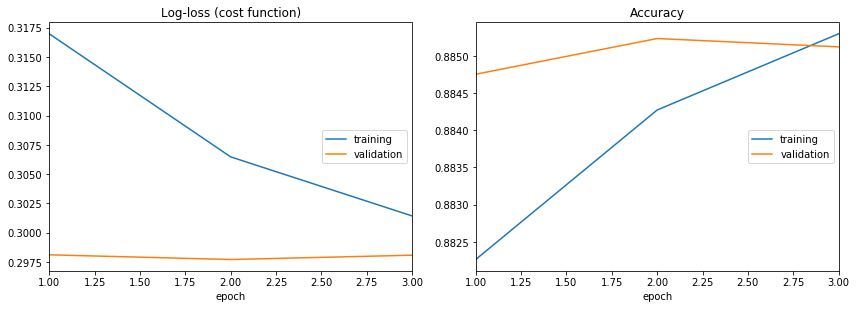

In [192]:
model3.fit(X_train, y_train, validation_data=[X_test, y_test], 
          batch_size=100, epochs=3, verbose=2,
          callbacks=[PlotLossesKeras()])

### Apply model to kaggle test

In [193]:
Xt = dataTesting['plot'].tolist()
voc = set(''.join(Xt))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}
Xt = [x[:max_len] for x in Xt]
# Convert characters to int and pad
Xt = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in Xt]
len(Xt)

3383

In [194]:
Xt_pad = sequence.pad_sequences(Xt, maxlen=max_len)
Xt_pad

array([[ 0,  0,  0, ..., 21, 52, 40],
       [ 0,  0,  0, ..., 61, 52, 40],
       [ 4, 11, 20, ..., 65, 15, 61],
       ...,
       [ 0,  0,  0, ..., 46, 52, 40],
       [ 0,  0,  0, ..., 61, 52, 40],
       [ 0,  0,  0, ..., 20, 52, 40]])

In [197]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model3.predict(Xt_pad)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF_3.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.50844</font>**

### d) Transfer Learning VGG16

### Read movie image data (otherwise)

In [198]:
images=os.listdir(os.path.join(path, 'images_resize_gray'))
indx= dataTraining.index

In [200]:
from keras.preprocessing import image

images_w = []
for img in images:
    img_path=os.path.join(path, 'images_resize_gray', img)  
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    images_w.append(x)

In [201]:
x=images_w
x = np.vstack( x )
x = x[indx]
x.shape

(7895, 32, 32, 3)

In [202]:
y = y_genres
y = np.vstack( y )
y.shape

(7895, 24)

### Split images into train and test

In [203]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=13)

### Import VGG16 Keras model 

In [204]:
model_vgg16 = VGG16(weights='imagenet', include_top=False)

### Create new X_train & X_test based on VGG16

In [205]:
X_train_new = model_vgg16.predict(X_train)
X_train_new.shape

(5289, 1, 1, 512)

In [206]:
X_test_new = model_vgg16.predict(X_test)
X_test_new.shape

(2606, 1, 1, 512)

In [207]:
X_new = model_vgg16.predict(x)
X_new.shape

(7895, 1, 1, 512)

In [208]:
indxt = dataTesting.index
xt = images_w
xt = np.vstack( xt )
xt = xt[indxt]
xt.shape

(3383, 32, 32, 3)

In [209]:
Xt_new = model_vgg16.predict(xt)
Xt_new.shape

(3383, 1, 1, 512)

### Create a Deep Learning model

In [214]:
model4 = Sequential()
model4.add(Flatten(input_shape=(1,1,512)))
model4.add(Dense(units=256, input_dim=1))
model4.add(Activation('tanh'))
model4.add(Dropout(0.5))      
model4.add(Dense(units=24, input_dim=1))
model4.add(Activation('softmax'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 24)                6168      
_________________________________________________________________
activation_26 (Activation)   (None, 24)                0         
Total params: 137,496
Trainable params: 137,496
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [215]:
model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Fit the model

In [216]:
model4.fit(X_new, y, epochs=50, verbose = 2)

Epoch 1/50
 - 2s - loss: 9.4468 - acc: 0.1377
Epoch 2/50
 - 1s - loss: 8.2476 - acc: 0.1600
Epoch 3/50
 - 1s - loss: 7.8536 - acc: 0.1896
Epoch 4/50
 - 1s - loss: 7.6837 - acc: 0.2085
Epoch 5/50
 - 1s - loss: 7.6077 - acc: 0.2100
Epoch 6/50
 - 1s - loss: 7.5564 - acc: 0.2187
Epoch 7/50
 - 1s - loss: 7.5448 - acc: 0.2179
Epoch 8/50
 - 1s - loss: 7.5197 - acc: 0.2191
Epoch 9/50
 - 1s - loss: 7.5161 - acc: 0.2179
Epoch 10/50
 - 1s - loss: 7.5183 - acc: 0.2100
Epoch 11/50
 - 1s - loss: 7.5134 - acc: 0.2144
Epoch 12/50
 - 1s - loss: 7.5107 - acc: 0.2182
Epoch 13/50
 - 1s - loss: 7.5002 - acc: 0.2153
Epoch 14/50
 - 1s - loss: 7.5035 - acc: 0.2165
Epoch 15/50
 - 1s - loss: 7.5019 - acc: 0.2205
Epoch 16/50
 - 1s - loss: 7.4887 - acc: 0.2218
Epoch 17/50
 - 1s - loss: 7.4891 - acc: 0.2194
Epoch 18/50
 - 1s - loss: 7.4920 - acc: 0.2243
Epoch 19/50
 - 1s - loss: 7.4886 - acc: 0.2233
Epoch 20/50
 - 1s - loss: 7.4904 - acc: 0.2238
Epoch 21/50
 - 1s - loss: 7.4967 - acc: 0.2181
Epoch 22/50
 - 1s - lo

### Apply model to kaggle test

In [217]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres =  model4.predict(Xt_new)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF_1.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.52287</font>**

### e) Transfer Learning ResNet50 and Fine tuning

### Import ResNet50 Keras model

In [226]:
model_ResNet50 = ResNet50(weights='imagenet', include_top=False)

### Create new X_train & X_test based on ResNet50

In [227]:
X_new = model_ResNet50.predict(x)
X_new.shape

(7895, 1, 1, 2048)

In [228]:
indxt = dataTesting.index
xt = images_w
xt = np.vstack( xt )
xt = xt[indxt]
xt.shape

(3383, 32, 32, 3)

In [229]:
Xt_new = model_ResNet50.predict(xt)
Xt_new.shape

(3383, 1, 1, 2048)

### Create a Deep Learning model

In [245]:
model5 = Sequential()
model5.add(Flatten(input_shape=(1,1,2048)))
model5.add(Dropout(0.5))
model5.add(Dense(units=512, input_dim=1))
model5.add(Activation('relu'))
model5.add(Dropout(0.5))
model5.add(Dense(units=24, input_dim=1))
model5.add(Activation('softmax'))
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               1049088   
_________________________________________________________________
activation_127 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 24)                12312     
_________________________________________________________________
activation_128 (Activation)  (None, 24)                0         
Total para

### Fine tuning

In [246]:
for layer in model5.layers:
    layer.trainable = False

### Visualize layer names and layer indices to see how many layers we should freeze:

In [247]:
for i, layer in enumerate(model5.layers):
    print(i, layer.name)

0 flatten_4
1 dropout_18
2 dense_31
3 activation_127
4 dropout_19
5 dense_32
6 activation_128


### Chose to train the top 2 inception blocks. We will freeze the first 3 layers and unfreeze the rest:

In [248]:
for layer in model5.layers[:3]:
    layer.trainable = False
for layer in model5.layers[3:]:
    layer.trainable = True

### Compile the model

In [249]:
model5.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Fit the model

In [250]:
model5.fit(X_new, y, epochs=30, verbose = 2)

Epoch 1/30
 - 4s - loss: 15.6177 - acc: 0.1139
Epoch 2/30
 - 2s - loss: 11.3689 - acc: 0.1265
Epoch 3/30
 - 2s - loss: 9.3339 - acc: 0.1429
Epoch 4/30
 - 2s - loss: 8.5334 - acc: 0.1642
Epoch 5/30
 - 2s - loss: 8.2525 - acc: 0.1767
Epoch 6/30
 - 2s - loss: 8.1105 - acc: 0.1853
Epoch 7/30
 - 2s - loss: 8.0708 - acc: 0.1849
Epoch 8/30
 - 2s - loss: 8.0603 - acc: 0.1829
Epoch 9/30
 - 2s - loss: 8.0661 - acc: 0.1866
Epoch 10/30
 - 2s - loss: 8.0174 - acc: 0.1877
Epoch 11/30
 - 2s - loss: 8.0542 - acc: 0.1887
Epoch 12/30
 - 2s - loss: 8.0440 - acc: 0.1814
Epoch 13/30
 - 2s - loss: 8.0270 - acc: 0.1877
Epoch 14/30
 - 2s - loss: 8.0131 - acc: 0.1901
Epoch 15/30
 - 2s - loss: 8.0316 - acc: 0.1882
Epoch 16/30
 - 2s - loss: 8.0268 - acc: 0.1904
Epoch 17/30
 - 2s - loss: 8.0348 - acc: 0.1925
Epoch 18/30
 - 2s - loss: 8.0404 - acc: 0.1826
Epoch 19/30
 - 2s - loss: 8.0377 - acc: 0.1963
Epoch 20/30
 - 2s - loss: 8.0336 - acc: 0.1900
Epoch 21/30
 - 2s - loss: 8.0523 - acc: 0.1832
Epoch 22/30
 - 2s - 

### Apply model to kaggle test

In [251]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres =  model5.predict(Xt_new)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF_2.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.51874</font>**

### Solution using both images and text

In [218]:
pred_img = pd.read_csv(os.path.join(path, 'pred_genres_img_RF_1.csv'), encoding='UTF-8', index_col=0)
pred_text = pd.read_csv(os.path.join(path, 'pred_genres_text_RF_2.csv'), encoding='UTF-8', index_col=0)
prediction=(pred_img+pred_text)/2

### Apply model to kaggle test

In [220]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

pd.DataFrame(prediction, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_img_RF_1.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.82333</font>**

### Voting of all models

In [12]:
pred1 = pd.read_csv(os.path.join(path, 'pred_genres_img_RF.csv'), encoding='UTF-8', index_col=0)
pred2 = pd.read_csv(os.path.join(path, 'pred_genres_img_RF_1.csv'), encoding='UTF-8', index_col=0)
pred3 = pd.read_csv(os.path.join(path, 'pred_genres_text_img_RF.csv'), encoding='UTF-8', index_col=0)
pred4 = pd.read_csv(os.path.join(path, 'pred_genres_text_img_RF_1.csv'), encoding='UTF-8', index_col=0)
pred5 = pd.read_csv(os.path.join(path, 'pred_genres_text_RF.csv'), encoding='UTF-8', index_col=0)
pred6 = pd.read_csv(os.path.join(path, 'pred_genres_text_RF_1.csv'), encoding='UTF-8', index_col=0)
pred7 = pd.read_csv(os.path.join(path, 'pred_genres_text_RF_2.csv'), encoding='UTF-8', index_col=0)
pred8 = pd.read_csv(os.path.join(path, 'pred_genres_text_RF_3.csv'), encoding='UTF-8', index_col=0)
#pred9 = pd.read_csv(os.path.join(path, 'pred_genres_img_RF_2.csv'), encoding='UTF-8', index_col=0)

prediction=(pred1+pred2+pred3+pred4+pred5+pred6+pred7+pred8)/8 #+pred9

### Apply to kaggle test

In [13]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

pd.DataFrame(prediction, index=dataTesting.index, columns=cols).to_csv('pred_genres.csv', index_label='ID')

## **<font color=red>Score in Kaggle = 0.85651</font>**

### Plot genres frequencies (Train) VS predicted genres frequencies (Test)

In [14]:
Result = pd.DataFrame(prediction, index=dataTesting.index, columns=cols)
Result = np.around(Result, 1)
Result = Result.values
Result

array([[0.1, 0.1, 0. , ..., 0.1, 0. , 0. ],
       [0.1, 0.1, 0. , ..., 0.2, 0. , 0. ],
       [0.1, 0.1, 0. , ..., 0.2, 0. , 0. ],
       ...,
       [0.1, 0.1, 0. , ..., 0.1, 0. , 0. ],
       [0.1, 0.1, 0. , ..., 0.1, 0. , 0. ],
       [0.1, 0.1, 0. , ..., 0.2, 0. , 0. ]])

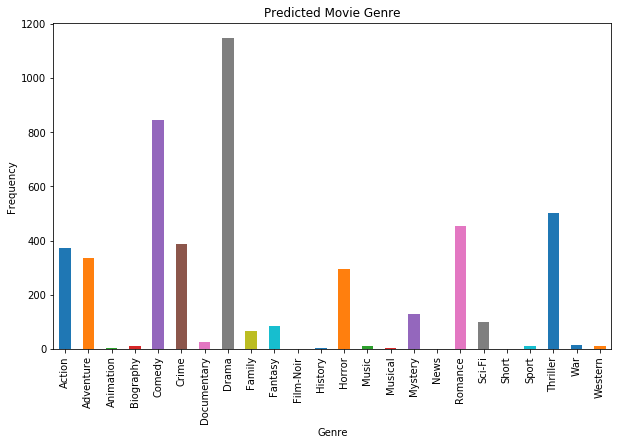

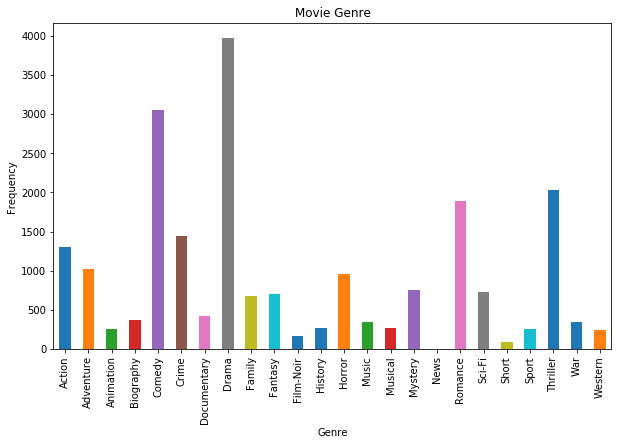

In [15]:
frequenciesPred = [sum(x) for x in zip(*Result)]

freq_seriesPred = pd.Series.from_array(frequenciesPred)

plt.figure(figsize=(10, 6))
ax = freq_seriesPred.plot(kind='bar')
ax.set_title('Predicted Movie Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Frequency')
ax.set_xticklabels(generos)
rects = ax.patches

frequencies = [sum(x) for x in zip(*y_genres)]
freq_series = pd.Series.from_array(frequencies)

plt.figure(figsize=(10, 6))
ax = freq_series.plot(kind='bar')
ax.set_title('Movie Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Frequency')
ax.set_xticklabels(generos)
rects = ax.patches